In [1]:
import sys

sys.path.append("../")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
import anndata as ad
#sys.path.append('/home/exx/git/Tangram/')  # uncomment for local import
#import telegraph as tg
import pyreadr

%load_ext autoreload
%autoreload 2
%matplotlib inline

#tg.__version__

/gstore/home/huangh83/miniconda3/envs/tangram/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
def jaccard_index(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    if not union:  # handle the case where both lists are empty
        return 1.0
    return len(intersection) / len(union)

In [4]:
def pp_adata(ad_sc):
    """ Preprocessing function for adata objects

    """

    # remove mitochondiral and ribosomal genes
    is_mt = ad_sc.var_names.str.startswith("MT-")
    is_rp = ad_sc.var_names.str.startswith(("RPS", "RPL","RP-","RP"))
    keep_genes = (~is_mt) & (~is_rp)
    ad_sc = ad_sc[:,keep_genes].copy()

    # remove cells with low counts
    sc.pp.filter_cells(ad_sc,min_counts=300)
    # remove lowly expressed genes
    sc.pp.filter_genes(ad_sc,min_counts=10)

    # get hvg genes
    ad_sc.layers['raw'] = ad_sc.X.copy()
    sc.pp.normalize_total(ad_sc,1e4)
    sc.pp.log1p(ad_sc)
    sc.pp.highly_variable_genes(ad_sc,n_top_genes=5000)
    ad_sc.layers['norm'] = ad_sc.X.copy()
    ad_sc.X = ad_sc.layers['raw'].copy()
    
    return ad_sc

In [5]:
REAL_DATA_SC_PTH = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_data/original_dataset/bc.h5ad'
ad_sc_all = ad.read_h5ad(REAL_DATA_SC_PTH)
ad_sc_all = ad_sc_all[ad_sc_all.obs.celltype_major != 'Normal Epithelial']

In [6]:
ad_sc_ER = ad_sc_all[ad_sc_all.obs.subtype == 'ER+']
ad_sc_TNBC = ad_sc_all[ad_sc_all.obs.subtype == 'TNBC']

In [7]:
ad_sc_all.obs.celltype_major.unique()

['Endothelial', 'CAFs', 'PVL', 'B-cells', 'T-cells', 'Myeloid', 'Plasmablasts', 'Cancer Epithelial']
Categories (8, object): ['B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'PVL', 'Plasmablasts', 'T-cells']

In [27]:
folder = '/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_eval/real/bc_dataset/cci/T-regs/macrophage_major/' #T-regs/PDL1_myeloid/'#'Tcell_major/'
patient = ['CID4290', 'CID4535', 'CID4465', 'CID44971']

In [28]:
result = pd.read_csv('/gstore/data/resbioai/tangram2_data/telegraph/res/ccc_eval/real/bc_dataset/cci/T-regs/macrophage_major/' #T-regs/PDL1_myeloid/'
           + patient[2] + '_composition.csv', index_col = 0)

In [30]:
DE_gene = []
for i in patient:
    DE_gene.append(pd.read_csv(folder+ i + '.csv', index_col=0))

In [31]:
receiver = [ 'T cells CD8+', 'T-regs', 'Cancer Epithelial', 'Macrophage']
signaler = ['Macrophage', 'T-regs', 'CAFs', 'Cancer Epithelial']

In [32]:
interaction = []
for i in receiver:
    for j in signaler:
        interaction.append(i + '_vs_' + j)

In [33]:
result = dict()
Tregs = [ i.lower() for i in [ 'ENTPD1', 'IL10', 'GZMB', 'TGFB1', 'CTLA4', 'LAG3', 'PRF1', 'NRP1', 'TIGIT']]
exhausion = [ i.lower() for i in [ 'TOX', 'CTLA4', 'PDCD1', 'LAG3', 'HAVCR2', 'TIGIT', 'IFNG', 'IL2', 'HIF1A']]
macrophages = [ i.lower() for i in [ 'CD80', 'CD86', 'CCR7', 'IFNG', 'CD40', 'HLA-DRA', 'HLA-DRB1', 'IL10', 'IL4', 'CD274']]
CAFS =  ['cd274', 'pdcd1lg2', 'ido1', 'lilrb4', 'lilrb2', 'cd276', 'c10orf54', 'lgals9', 'tnfrsf14']

marker = (Tregs +  exhausion + macrophages + CAFS)
for interact in interaction:
    comparison_df = pd.DataFrame()
    for i in range(len(DE_gene)):
        beta = DE_gene[i].copy()
        result_temp = beta[(beta.inter == interact) * (beta.features.isin(marker))]
        result_temp['patient'] = patient[i]
        comparison_df = pd.concat([comparison_df, result_temp])
            
    result[interact] = comparison_df.copy()

/local/6301955/ipykernel_21657/234562334.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_temp['patient'] = patient[i]
/local/6301955/ipykernel_21657/234562334.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_temp['patient'] = patient[i]
/local/6301955/ipykernel_21657/234562334.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [35]:
result_df = pd.DataFrame()

for key in result.keys():
    result_df = pd.concat([result_df, result[key]])

In [36]:
result_df

,features,beta,inter,patient
4063896,tnfrsf14,-0.807202,T cells CD8+_vs_Macrophage,CID4290
4065640,il10,-0.302183,T cells CD8+_vs_Macrophage,CID4290
4067090,ctla4,4.815153,T cells CD8+_vs_Macrophage,CID4290
4067338,pdcd1,-0.082645,T cells CD8+_vs_Macrophage,CID4290
4067980,tigit,3.829366,T cells CD8+_vs_Macrophage,CID4290
...,...,...,...,...
1786986,ccr7,-0.740220,Macrophage_vs_Cancer Epithelial,CID44971
1788355,cd40,0.588499,Macrophage_vs_Cancer Epithelial,CID44971
1789428,tgfb1,-5.993194,Macrophage_vs_Cancer Epithelial,CID44971
1789820,lilrb2,2.814929,Macrophage_vs_Cancer Epithelial,CID44971


In [39]:
result_df2 = result_df.copy()
result_df2.index = result_df2.features

In [47]:
gene_list = exhausion
S = 'Cancer Epithelial'
R = 'T-regs'
comparison_df = pd.DataFrame()
for pat in result_df2['patient'].unique()[2:]:
    positive = result_df2[(result_df2['inter'] == R + '_vs_' + S) * 
                      (result_df2['patient'] == pat)]['beta']    
    
    comparison_df[pat] =  positive

In [49]:
comparison_df.index = comparison_df.index.str.upper()

comparison_set = [ i.upper() for i in gene_list]

intersect = []
for i in comparison_set:
    if i in comparison_df.index:
        intersect.append(i)

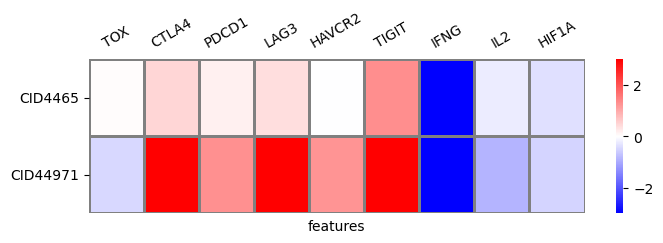

In [50]:
plt.figure(figsize=(8, 2)) #, dpi=80)

sns.heatmap(comparison_df.loc[intersect].T, cmap = 'bwr', center = 0, vmin = -3.0, vmax = 3.0, linewidths=1, linecolor='grey',)
plt.yticks(rotation = 0)
plt.xticks(fontsize = 18)
plt.tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)
plt.xticks(rotation = 30)
plt.show()